# LangGraph tutorial

One very usefull way of developing Agentic AI is with the usage of graph of agents. A Graph of agents is a "step by step" instructions on how an Agentic AI will work, in order to achieve the final solution. It can go from simply a step by step procedure, or as complex as handling a network of agents, and how they interact with each [other](https://langchain-ai.github.io/langgraph/concepts/multi_agent/).

In here we'll work with a simple step by step agent. We'll start creating a custom [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) in order for us to be able to store a user input query, simulate a talk between two people, and finally sumarize the talk between them.

We'll also create a more simple agent, capable of searching the web via the [Tavily API](https://www.tavily.com/), and summarize in a Markdown format the results found, based on the user query.

In the end, we'll add some sort of short term memory on the last agent, in order to exemplify the usage of the [Checkpointer](https://langchain-ai.github.io/langgraph/concepts/memory/#short-term-memory).

## State

Langgraph utilizes states as the way to pass message between nodes. There's also a handy message state called `MessagesState`, that is basically a `TypedDict` with a reducer function responsible for keep adding messages in the `message` field. Let's create a similar state, but we'll add a `user_input` field, as well as a `summary` field. The main idea here (and this is totally random) is that we'll store the user query in the `user_input` field, we'll add the messages between the nodes in the `messages` list, and we'll output on the last node a summary of everything that the graph worked, on the the `summary` field.

In [1]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_input: str
    summary: str

## Nodes

Each node is responsible for one specific action in a LangGraph graph. So we'll create some nodes to exemplify this:

1. Decide the amount of messages the `user_input` can have to tell a story about two people talking about the `user_input` query.
2. Create the talks between the two people, and add it in the `messages` field.
3. Summarize the conversation found in the `messages` field.

Of course this is only for showing how one can utilize the nodes to create a simple graph. Lather on we'll create a more usefull agent.

In [2]:
# Let's load the environment variables
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
# Let's start with the LLM and the Langgraph builder, StateGraph
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph

# Instantiate the LLM
llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

# Create the graph builder
graph_builder = StateGraph(GraphState)

In [4]:
# Create the first node to decide the amount of messages
def decide_amount_of_messages(state: GraphState):
    # Clean the state variables that we'll need to use, so that we always start with a clean slate
    state['messages'] = []
    state['summary'] = ""

    # Get the user input
    user_input = state.get('user_input', '')
    if not user_input:
        raise ValueError("User input is required to decide the amount of messages.")

    # Create a system prompt to decide the amount of messages
    system_prompt = """
    You are a novel writer tasked with creating a very short store about two people talking about a given topic.
    In this part of the process, you'll need to decide how many messages the conversation will have, and only this.
    The amount of messages should be between 2 and 50, the messages should be short and capable ot telling a story about the two people talking about the given topic.
    Do not write the messages, just return the amount of messages that the conversation will have and instructions to the next node to create the messages.
    """
    human_prompt = f"""
    User input to be handled as a topic: {user_input}
    """
    prompt = [system_prompt, human_prompt]
    response = llm.invoke(prompt)
    
    # Returning only the messages, will let the LangGraph to utilize the redurecer on the 'messages' field, and it'll add the message to the state. 
    # Since this is the first node, this'll be the firt message on the list.
    return {'messages': response.content} 

# Add the node to the graph builder
graph_builder.add_node("decide_amount_of_messages", decide_amount_of_messages)

In [5]:
# Create the second node, to create the actuall message conversation.
from langchain_core.messages import AIMessage
def create_messages(state: GraphState):
    # Get the instruction from the state. It should be the first message in the list.
    instruction_message = state['messages'][0]
    user_input = state.get('user_input', '')
    if not instruction_message:
        raise ValueError("No instruction message found in the state.")
    
    # Create the system prompt to create the messages
    system_prompt = """
    You are a novel writer tasked with creating a very short store about two people talking about a given topic.
    In this part of the process, you'll need to create the messages that will be used in the conversation.
    You already have the instructions on how to create the messages, as well as the topic to be used.
    The output should be a JSON list of messages, where each message is a dictionary with the following fields:
    - talker: The name of the person talking, it can be any name you want, as long as it is consistent throughout the conversation.
    - content: The content of the message, it should be short and capable of telling a
    """
    human_prompt = f"""
    User input to be handled as a topic: {user_input}
    Instructions to create the messages: {instruction_message}
    """
    prompt = [system_prompt, human_prompt]
    # Just for kicks, let's create a dictionary output and parse this into a message list, that'll add on the state
    class TalkingMessage(TypedDict):
        talker: str
        content: str
    class Conversation(TypedDict):
        messages: list[TalkingMessage]
    
    talk_messages = []
    response = llm.with_structured_output(Conversation).invoke(prompt)

    for message in response['messages']:
        talk_messages.append(AIMessage(content=message['content'], additional_kwargs={'talker': message['talker']}))

    return {'messages': talk_messages}

# Add the node to the graph builder
graph_builder.add_node("create_messages", create_messages)

In [6]:
# Now let's add the last node, to summarize the conversation
def summarize_conversation(state: GraphState):
    # Get the messages from the state
    messages = state['messages']
    if not messages:
        raise ValueError("No messages found in the state.")
    
    # Create the system prompt to summarize the conversation
    system_prompt = """
    You are a novel writer tasked with summarizing a conversation between two people.
    In this part of the process, you'll need to summarize the conversation found in the messages.
    The output should be a short summary of the conversation, that can be used to understand what was talked about.
    Also, make the output as a Markdown text, and include the messages in it.
    """
    human_prompt = f"""
    Messages to be summarized: {messages}
    """
    prompt = [system_prompt, human_prompt]
    
    response = llm.invoke(prompt)
    
    # Add the summary to the state
    return {'summary': response.content}
# Add the node to the graph builder
graph_builder.add_node("summarize_conversation", summarize_conversation)

In [7]:
# Add the edges between the nodes
from langgraph.graph import START, END

graph_builder.add_edge(START, "decide_amount_of_messages")
graph_builder.add_edge("decide_amount_of_messages", "create_messages")
graph_builder.add_edge("create_messages", "summarize_conversation")
graph_builder.add_edge("create_messages", END)

# Compile the graph
graph = graph_builder.compile()

In [8]:
# Test user input
test_state = GraphState(
    user_input="What is the meaning of life, and why it's 42?",
    messages=[],
    summary=""
)
# Run the graph with the test state
result = graph.invoke(test_state)

In [9]:
for message in result['messages']:
    print('---')
    print(f'Content: {message.content}')
    print(f'Talker: {message.additional_kwargs.get("talker", "Unknown")}')

---
Content: The conversation will have 7 messages.

Instructions to the next node: 
Create 7 short messages that tell a story about two people discussing the meaning of life and why it's 42. Consider including elements of humor, curiosity, and insight. Ensure that the conversation flows logically and that the topic is explored in a creative way.
Talker: Unknown
---
Content: I've always wondered, what's the meaning of life?
Talker: Alex
---
Content: You know, I think it's 42.
Talker: Ben
---
Content: 42? That's random. Why 42?
Talker: Alex
---
Content: Well, didn't Douglas Adams say that's the answer to the ultimate question of life, the universe, and everything?
Talker: Ben
---
Content: From 'The Hitchhiker's Guide to the Galaxy'? I read that, but I never thought much of it.
Talker: Alex
---
Content: Exactly! It's humorous, but also profound. Maybe the meaning of life is simply to find joy in the journey, not the destination.
Talker: Ben
---
Content: Hmm, I think you might be onto som

In [10]:
from IPython.display import display, Markdown
display(Markdown(result['summary']))

## Conversation Summary
The conversation revolves around two individuals, Alex and Ben, discussing the meaning of life. The exchange begins with Alex's inquiry about the meaning of life, to which Ben responds with the enigmatic answer, "42." 

### The Conversation
* Alex initiates the conversation by asking, **"I've always wondered, what's the meaning of life?"**
* Ben replies with a mysterious answer, **"You know, I think it's 42."** 
* Alex seeks clarification, finding Ben's answer **"random,"** and asks, **"Why 42?"**
* Ben references Douglas Adams' work, stating, **"Well, didn't Douglas Adams say that's the answer to the ultimate question of life, the universe, and everything?"**
* Alex recalls reading "The Hitchhiker's Guide to the Galaxy" but hadn't given it much thought, saying, **"From 'The Hitchhiker's Guide to the Galaxy'? I read that, but I never thought much of it."**
* Ben offers a profound interpretation, suggesting, **"Exactly! It's humorous, but also profound. Maybe the meaning of life is simply to find joy in the journey, not the destination."**
* Alex contemplates Ben's insight and concludes, **"Hmm, I think you might be onto something there. So, 42 is like a reminder to enjoy the ride?"**

### Insights
The conversation creatively explores the topic of life's meaning, integrating humor and curiosity. It highlights how the answer "42" from Douglas Adams' science fiction series can be seen not just as a quirky response but as a metaphor for finding joy and meaning in life's journey rather than its destination.

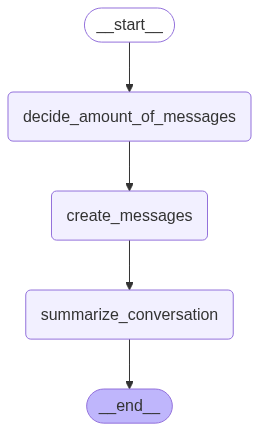

In [11]:
# It's also possible to see the graph visually, this is a neat feature of LangGraph that'll help you to understand the flow of the graph.
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

## An agent with a tool

Now that we have played a little with agents, let's create an agent that'll search the web for a specific query, and generate a summary over it.
For this we'll utilize the Tavily API, and Groq LLM with Llama.

In [12]:
# Create the Tavily search tool
from langchain_tavily import TavilySearch
search = TavilySearch(max_results=5)
tools = [search]

In [13]:
# Create an agent with the tavily search tool
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools)

In [14]:
# Now let's create the graph with the default MessagesState State, to search the web for a specific query and summarize the result.
# This should be made with 2 nodes, one to search the web, and another to summarize the result.
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage

graph_builder = StateGraph(MessagesState)

def search_node(state: MessagesState):
    # Get the user input from the state, this should always be the first messages in the state
    user_input = state['messages'][-1].content if state['messages'] else None
    if not user_input:
        raise ValueError("User input is required to search the web.")
    
    # Invoke the search tool with the user input
    results = search.invoke({'query': user_input})
    if not results['results']:
        raise ValueError("No search results found.")
    # Squash the results into valid ToolMessages
    found_results = []
    for result in results['results']:
        # Create a ToolMessage for each result
        search_result = AIMessage(
            content=result['content'],
            kwargs={
                'url': result.get('url', ''),
                'title': result.get('title', '')
            }
        )
        # Add the ToolMessage to the state messages
        found_results.append(search_result)
    # Add the search results to the state
    return {'messages': found_results}

graph_builder.add_node("search", search_node)

In [15]:
# Create the node to summarize the search results
def summarize_search_results(state: MessagesState):
    # Create the system prompt to summarize the search results
    system_prompt = """
    You are a web researcher tasked with summarizing search results.
    In this part of the process, you'll need to summarize the search results found previously.
    The output should be a short summary of the search results, that can be used to understand what was found.
    Also, make the output as a Markdown text.
    Keep the URL and reference the results in the Markdown text.
    """
    human_prompt = f"""
    Search results to be summarized: {state['messages']}
    """
    prompt = [system_prompt, human_prompt]
    
    response = llm.invoke(prompt)
    
    # Add the summary to the state
    return {'messages': [response.content]}

graph_builder.add_node("summarize_search_results", summarize_search_results)

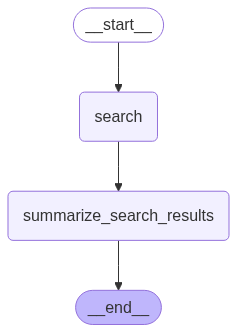

In [16]:
# Now create the edges, compile the graph, visualize it and test it
graph_builder.add_edge(START, "search")
graph_builder.add_edge("search", "summarize_search_results")
graph_builder.add_edge("summarize_search_results", END)
# Compile the graph
graph = graph_builder.compile()
# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
# Test the graph with a user input
test_state = MessagesState(messages=[AIMessage(content="Search for the meaning of life?")])
result = graph.invoke(test_state)

In [18]:
display(Markdown(result['messages'][-1].content))

### Summary of Search Results

The search results explore the concept of the meaning of life from various perspectives, including psychological, philosophical, and literary viewpoints.

* **Viktor Frankl's Perspective**: Viktor Frankl, an Austrian psychiatrist and Holocaust survivor, wrote "Man's Search for Meaning," a book that explores his experiences in Nazi concentration camps and his psychotherapeutic method. Frankl proposes that the meaning of life can be found through three ways: completing tasks, caring for others, or finding meaning in suffering with dignity. [1](https://medium.com/@DenisBischof/search-for-meaning-in-life-based-on-viktor-e-frankl-994a72fbd700) [2](https://en.wikipedia.org/wiki/Man%27s_Search_for_Meaning)

* **Finding Purpose in Life**: The search results also suggest that finding one's purpose in life involves exploring what gives life meaning and learning to live well with others. [3](https://www.ivpress.com/pages/content/search-for-meaning-finding-purpose-in-life?srsltid=AfmBOopwPMsE1AO964EH-KQe_ibvdYs9JBIk17XNjxbrTING8hNgnAg7)

* **Psychological Research**: Researchers define meaning in life as comprising three themes: believing one's life and contributions matter, feeling that life makes sense, and pursuing fulfilling goals. [4](https://greatergood.berkeley.edu/article/item/three_ways_to_see_meaning_in_your_life)

* **Spiritual and Mystical Perspectives**: Some sources discuss the mystical meaning of life and the role of science and mysticism in understanding transpersonal experiences. [5](https://www.amazon.com/Search-Meaning-Life-Reflections-Experience/dp/076481107X)

Overall, the search results indicate that the meaning of life is a complex and multifaceted concept that can be explored through various lenses, including psychology, philosophy, literature, and spirituality.

References:

[1] https://medium.com/@DenisBischof/search-for-meaning-in-life-based-on-viktor-e-frankl-994a72fbd700
[2] https://en.wikipedia.org/wiki/Man%27s_Search_for_Meaning
[3] https://www.ivpress.com/pages/content/search-for-meaning-finding-purpose-in-life?srsltid=AfmBOopwPMsE1AO964EH-KQe_ibvdYs9JBIk17XNjxbrTING8hNgnAg7
[4] https://greatergood.berkeley.edu/article/item/three_ways_to_see_meaning_in_your_life
[5] https://www.amazon.com/Search-Meaning-Life-Reflections-Experience/dp/076481107X

## Memory

Now let's continue by adding some sort of memory for our agent. For this, let's add a generic chat node as the first node of the agent and, if the user request is to search the web for something, we'll direct it to the search and summarize node, otherwise we'll just chat with the user. There are some ways of making this "if" scenarion, we can add a [`coditional_edge`](https://langchain-ai.github.io/langgraph/concepts/low_level/?h=command#conditional-edges), or utilize the [`Command`](https://langchain-ai.github.io/langgraph/concepts/low_level/?h=command#command) structure. The main difference is that the `Command` can update the state as well as route the information, while the `conditional_edge` can only route the information. Since the `search_node` is expecting the first message to be the search message, we'll add a `conditional_edge` at the beginning of the graph, if the user requested a search, we'll send it to the `search_node`, otherwise we send it to the new `chat_node`.

In [19]:
# Restart the graph builder
graph_builder = StateGraph(MessagesState)

# Add the search node and summarize node to the graph builder
graph_builder.add_node("search_node", search_node)
graph_builder.add_node("summarize_search_results", summarize_search_results)

# Create the method to detect if the user wants to search the web or not. We'll utilize a slightly more complex way of detecting this
# by letting the LLM decide what the message is requesting (a search or a chat).
def route(state: MessagesState):
    # Get the last message from the state
    user_message = state['messages'][-1].content if state['messages'] else None
    if not user_message:
        raise ValueError("User message is required to actually do something.")
    
    # Create a custom structured output to handle the decision
    class DecisionOutput(TypedDict):
        search: str

    # Create a system prompt to decide if the user wants to search the web or not
    system_prompt = """
    You are an analyst tasked with deciding if the user wants to search the web or not.
    In this part of the process, you'll need to analyze the user message and decide if it is a search request or not.
    The output should be only a JSON with the following keys:
     - search: boolean value, where True means that the user wants to search the web, and False means that the user wants to chat.
    """
    human_prompt = f"""
    User message to be analyzed: {user_message}
    """
    prompt = [system_prompt, human_prompt]
    response = llm.with_structured_output(DecisionOutput).invoke(prompt)
    # Return the decision based on the response
    if response['search'].lower() == 'true':
        return "search_node"
    
    return "chat_node"
    
# Create a chat node that can talk, and direct for the next node based on the user input
def chat_node(state: MessagesState):
    # Get the last message from the state
    user_message = state['messages'][-1].content if state['messages'] else None
    if not user_message:
        raise ValueError("User message is required to actually do something.")

    # Create a system prompt for the chat node
    system_prompt = """
    You are a chat assistant. Your job is to respond to user messages in a helpful and informative way.
    """
    human_prompt = f"""
    User message: {user_message}
    """
    prompt = [system_prompt, human_prompt] + state['messages'] # Since we are working in a chat node, let's send everything we have in the state messages to the LLM.
    response = llm.invoke(prompt)
    # Process the response and continue the conversation
    return {'messages': [AIMessage(content=response.content)]}

# Add the nodes to the graph builder
graph_builder.add_node('chat_node', chat_node)

# Add the edges
graph_builder.add_conditional_edges(START, route, ['chat_node', 'search_node']) # We start with the routing edge
graph_builder.add_edge("chat_node", END) # From the chat wen can only go to the end
graph_builder.add_edge("search_node", "summarize_search_results") # From the search, we go to the summarize node
graph_builder.add_edge("summarize_search_results", END)

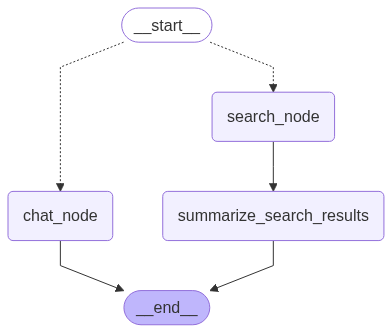

In [20]:
# Now let's compile the graph and visualize it
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
# Now let's test the graph with a user input
# First a little chat
test_state = MessagesState(messages=[AIMessage(content="Hello, my name is Mateus.")])
result = graph.invoke(test_state)
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

 Nice to meet you! How can I assist you today? Do you have any questions, need help with something, or just want to chat? I'm here to help!


In [22]:
# Let's try a simple search
test_state = MessagesState(messages=[AIMessage(content="Search for the meaning of life?")])
result = graph.invoke(test_state)
display(Markdown(result['messages'][-1].content))

### Summary of Search Results

The search results explore the concept of the meaning of life from various perspectives, including psychological, philosophical, and spiritual viewpoints. Here's a brief overview of the findings:

* **Viktor Frankl's Perspective**: Viktor Frankl, an Austrian psychiatrist and Holocaust survivor, wrote extensively on the topic in his book "Man's Search for Meaning" [1]. Frankl proposes that finding meaning in life is crucial, especially in the face of suffering. He suggests that individuals can find meaning through:
	+ Completing tasks
	+ Caring for others
	+ Finding dignity in suffering
* **Psychological Research**: Studies suggest that the experience of meaning in life can be broken down into three interrelated facets [2]:
	+ Significance (mattering to others and oneself)
	+ Coherence (making sense of life)
	+ Purpose (orienting toward goals)
* **Spiritual and Philosophical Views**: The search for meaning is also explored in spiritual and philosophical contexts, including [3][4]:
	+ The importance of living well with others
	+ The role of science and mysticism in understanding the mystical meaning of life

These perspectives collectively highlight the complexity and multifaceted nature of the search for meaning in life.

### References

* [1] [Man's Search for Meaning - Wikipedia](https://en.wikipedia.org/wiki/Man%27s_Search_for_Meaning)
* [2] [Three Ways to See Meaning in Your Life](https://greatergood.berkeley.edu/article/item/three_ways_to_see_meaning_in_your_life)
* [3] [Search for Meaning in Life | Viktor E. Frankl - Medium](https://medium.com/@DenisBischof/search-for-meaning-in-life-based-on-viktor-e-frankl-994a72fbd700)
* [4] [The Search for Meaning: Finding Your Purpose in Life](https://www.ivpress.com/pages/content/search-for-meaning-finding-purpose-in-life?srsltid=AfmBOopwPMsE1AO964EH-KQe_ibvdYs9JBIk17XNjxbrTING8hNgnAg7)

In [23]:
# Let's check if it knows the name
test_state = MessagesState(messages=[AIMessage(content="What is my name?")])
result = graph.invoke(test_state)
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

 I'm sorry, but I don't have access to personal information about you, including your name. I'm here to provide general information and answer questions, but I don't have the ability to retain or access personal data. If you'd like to share your name with me, I'd be happy to chat with you!


In [24]:
# As expected, it has no idea of what was previously talked, let's add a checkpointer to fix this.
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()
# We need to rebuild the graph to add the checkpointer
graph_builder = StateGraph(MessagesState)
graph_builder.add_node('chat_node', chat_node)
graph_builder.add_node('search_node', search_node)
graph_builder.add_node('summarize_search_results', summarize_search_results)
graph_builder.add_conditional_edges(START, route, ['chat_node', 'search_node']) # We start with the routing edge
graph_builder.add_edge("chat_node", END) # From the chat wen can only go to the end
graph_builder.add_edge("search_node", "summarize_search_results") # From the search, we go to the summarize node
graph_builder.add_edge("summarize_search_results", END)
# Now compile the graph with the checkpointer
graph = graph_builder.compile(checkpointer=checkpointer)

In [25]:
# Let's test the graph with the same 3 messages we created, for this we need to add a thread id so it can search, let's create a random
# thread id now
from uuid import uuid4
thread_id = f'memoryTest_{uuid4()}'
config = {'configurable': {'thread_id': thread_id}}

# And let's invoke the graph with the thread it
input = 'Hello, my name is Mateus.'
result = graph.invoke({'messages': [{'role': 'user', 'content': input}]}, config)
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

Hello Mateus! It's nice to meet you. Is there something I can help you with or would you like to chat?


In [26]:
# And let's invoke the graph with the thread it
input = 'Search the meaning of life?'
result = graph.invoke({'messages': [{'role': 'user', 'content': input}]}, config)
result['messages'][-1].pretty_print()

================================ Human Message =================================

### Summary of Search Results 

The search results provide various perspectives on the meaning of life, drawing from psychology, philosophy, and spirituality. 

* **Psychological Perspectives**: 
  - Psychologists define meaning in life through three main themes: 
    1. Believing one's life and contributions matter to others and oneself.
    2. Feeling that life makes sense.
    3. Actively pursuing fulfilling goals. 
  - Strategies like logotherapy, meaning therapy, and existential therapy are used to help individuals find meaning.

* **Philosophical Views**: 
  - The concept of the meaning of life is explored through various philosophical ideas and abstract objects.
  - The discussion includes topics like causality, consciousness, and the nature of reality.

* **Resources for Further Exploration**:
  - **Book**: "Search for the Meaning of Life: Essays and Reflections on the Mystical Experience" on [Ama

In [27]:
# Now, let's ask for the name again, it should be able to remember it
input = 'What is my name?'
result = graph.invoke({'messages': [{'role': 'user', 'content': input}]}, config)
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

Your name is Mateus. We started our conversation with you introducing yourself as Mateus. How can I assist you further today?


In [28]:
input = 'What have we talked about?'
result = graph.invoke({'messages': [{'role': 'user', 'content': input}]}, config)
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

We've had a conversation about the meaning of life! You initially asked me to search for the meaning of life, and I provided some insights from psychology and philosophy. I also summarized our conversation and provided some resources for further exploration. Additionally, we exchanged greetings and you told me your name is Mateus. That's a quick recap!
